In [35]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, './simile')

import importlib
import simile as sml
importlib.reload(sml)

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from rdkit.Chem import MolFromSmiles, rdFMCS, MolToInchiKey

/var/folders/yd/wk0sjvrj5q379l6mjply6h4c0000gn/T/ipykernel_17721/1739690547.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Option 1: Load Example Data

In [72]:
mzi = []
pmz = []
mols = []
spec_name = None
tolerance = .01

for ex in ['1','5a','5b','5c']:
    df = pd.read_json('./example_data/fig{}.json'.format(ex))
    mzi.append(np.array((df.iloc[0].spectrum)))
    mzi.append(np.array((df.iloc[1].spectrum)))

    pmz.append(df.iloc[0].precursor_mz)
    pmz.append(df.iloc[1].precursor_mz)

    mols.append(MolFromSmiles(df.iloc[0].smiles))
    mols.append(MolFromSmiles(df.iloc[1].smiles))


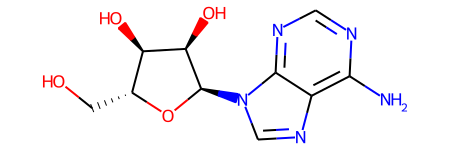

In [37]:
mols[6]

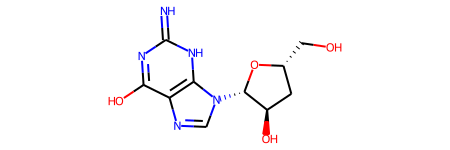

In [38]:
mols[7]

In [39]:
res = rdFMCS.FindMCS([mols[-1],mols[-2]],timeout=10,ringMatchesRingOnly=False)
A = mols[-1].GetNumBonds()
B = mols[-2].GetNumBonds()
AB = res.numBonds 
jaccard_similarity = AB / (A+B-AB)
jaccard_similarity

0.8260869565217391

## Option 2: Generate Synthetic Data

In [60]:
mzi = []
pmz = []
mols = []
spec_name = []
tolerance = .01

a = 20 + np.random.random_sample()/10
b = 8  + np.random.random_sample()/10
c = 5  + np.random.random_sample()/10
d = 1  + np.random.random_sample()/10

mzi.append(np.array([[c,b,a,a+c,a+b,a+b+c]
                for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('none')

mzi.append(np.array([[c,b+d,a,a+c,a+b+d,a+b+c+d]
                for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('b')


mzi.append(np.array([[c,c+d,b,b+d,a,a+c+d,a+b+d,a+b+c+d,a+b+c+2*d]
                 for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('b+c')


mzi.append(np.array([[c+d,b,a,a+c+d,a+b,a+b+c+d]
                 for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('c')


## Option 3: Load GNPS Data

In [69]:
mzi = []
pmz = []
mols = []
spec_name = None
tolerance = .33


import requests
url1 = 'https://metabolomics-usi.ucsd.edu/json/?usi1=mzspec:GNPS:TASK-e3642744dc754c73ab780797577c62d2-spectra/specs_ms.mgf:scan:2021'
url2 = 'https://metabolomics-usi.ucsd.edu/json/?usi1=mzspec:GNPS:TASK-e3642744dc754c73ab780797577c62d2-spectra/specs_ms.mgf:scan:2025'

r = requests.get(url1)
mzi.append(np.asarray(r.json()['peaks']).T)
pmz.append(r.json()['precursor_mz'])

r = requests.get(url2)
mzi.append(np.asarray(r.json()['peaks']).T)
pmz.append(r.json()['precursor_mz'])


## SIMILE Substitution Matrix, Alignment Score, and Alignment P-value

### Select Spectra

In [81]:
## Subsample spectra of interest by slicing 
mzs = np.array([mz for (mz,i) in mzi])[[6,7]]
pmzs = np.array(pmz)[[6,7]]

/var/folders/yd/wk0sjvrj5q379l6mjply6h4c0000gn/T/ipykernel_17721/3520650546.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mzs = np.array([mz for (mz,i) in mzi])[[6,7]]


### Run SIMILE

Scores:
  (0, 0)	0.19993766921435227
  (0, 1)	0.7302342670625129
  (1, 1)	0.053552895097384576, 
P-values:
  (0, 0)	0.12997732671904805
  (0, 1)	0.015407993214153051
  (1, 1)	0.14670063323290766, 
Matches: (24, 0)


<timed exec>:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 746 ms, sys: 356 ms, total: 1.1 s
Wall time: 368 ms


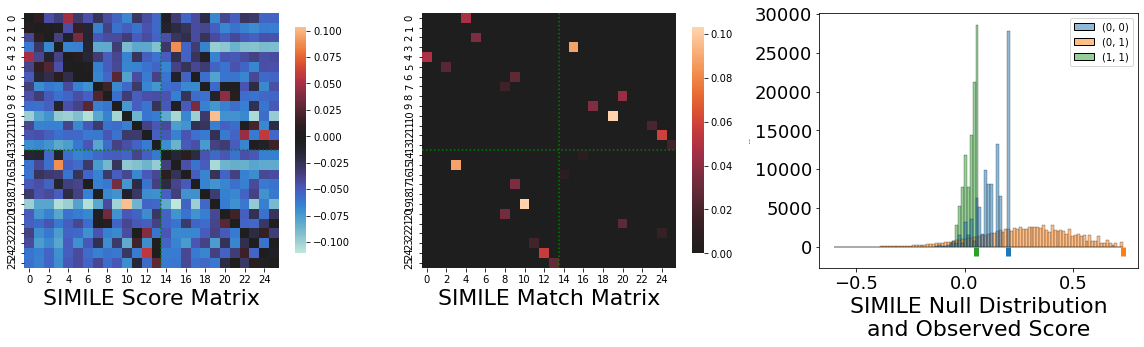

In [82]:
%%time
# %matplotlib inline
sml = importlib.reload(sml)

# SIMILE ##############################################################################################################
S, spec_ids = sml.similarity_matrix(mzs, pmzs=pmzs, tolerance=tolerance)

# Each fragment ion can only match once
# M = sml.pairwise_match(S)

# Interspectral vs Intraspectral Comparison
# C = sml.inter_intra_compare(M,spec_ids)

# Each fragment ion can only match once per fragmentation spectra
M = sml.multiple_match(S,spec_ids)

# Symmetric vs Asymmetric Comparison
C = sml.sym_compare(M,spec_ids)

spec_scores,pval,null_dist = sml.z_test(S,M,C, spec_ids, return_dist=True, log_size=5)

# Plotting ###########################################################################################################
print('Scores:\n{}, \nP-values:\n{}, \nMatches: {}'.format(spec_scores, pval, (((M.multiply(C))>0).sum(),-((M.multiply(C))<0).sum())))
fig,ax= plt.subplots(1,3,figsize=(16,16))

sns.heatmap(S, 
            cbar_kws={"shrink": .2},
            center=0,linewidths=0.0, rasterized=True, ax=ax[0])
ax[0].xaxis.set_label_text('SIMILE Score Matrix', fontsize=22)
ax[0].vlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[0].hlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')


sns.heatmap(S*M.toarray()*C,
            cbar_kws={"shrink": .2},
            center=0,linewidths=0.0, rasterized=True, ax=ax[1])
ax[1].xaxis.set_label_text('SIMILE Match Matrix', fontsize=22)
ax[1].vlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[1].hlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[1].set_aspect(1.0/ax[2].get_data_ratio(), adjustable='box')


sns.histplot(null_dist.real, ax=ax[2], stat='count',bins=100)
legend = ax[2].get_legend()
handles = legend.legendHandles
legend.remove()
ax[2].legend(handles, list(zip(spec_scores.row,spec_scores.col)))
ax[2].xaxis.set_label_text('SIMILE Null Distribution\nand Observed Score', fontsize=22)
ax[2].yaxis.set_label_text('Count', fontsize=2)
ax[2].xaxis.set_tick_params(labelsize=18)
ax[2].yaxis.set_tick_params(labelsize=18)
ax[2].vlines(spec_scores.data,0,-ax[2].get_ylim()[1]/25,linewidth=5,color=sns.color_palette())
ax[2].set_aspect(.8/ax[2].get_data_ratio(), adjustable='box')

fig.tight_layout()
fig.show()

In [49]:
sml.matching_ions_report(S,M,C,mzs,pmzs).query('type=="pro"').sort_values('score',ascending=False).head(50)

,spec_key_1,spec_key_2,pmz_1,pmz_2,mz_1,mz_2,mz_diff,nl_diff,score,type
95,0,0,855.14899,855.14899,1653.546997,1671.463013,-17.916016,NaN,0.092032,pro
94,0,0,855.14899,855.14899,1504.845947,1667.746948,-162.901001,NaN,0.057273,pro
89,0,0,855.14899,855.14899,1288.602051,1306.604004,-18.001953,NaN,0.056184,pro
87,0,0,855.14899,855.14899,1215.323975,1234.406982,-19.083008,NaN,0.047011,pro
90,0,0,855.14899,855.14899,1295.692993,1314.651001,-18.958008,NaN,0.043593,pro
91,0,0,855.14899,855.14899,1361.749023,1480.712036,-118.963013,NaN,0.041622,pro
7,0,0,855.14899,855.14899,296.296997,298.386993,-2.089996,2.089996,0.036427,pro
75,0,0,855.14899,855.14899,1022.565979,1048.494995,-25.929016,NaN,0.035859,pro
83,0,0,855.14899,855.14899,1119.621948,1266.614990,-146.993042,NaN,0.035471,pro
92,0,0,855.14899,855.14899,1374.505005,1387.576050,-13.071045,NaN,0.034919,pro
